In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import bootcampviztools as bct
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

df_mad = pd.read_csv('..\data_sample\mad_clean.csv')

In [13]:
df_mad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25609 entries, 0 to 25608
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Fecha            25609 non-null  object
 1   Pasajeros        25609 non-null  int64 
 2   Origen           25609 non-null  object
 3   Destino          25609 non-null  object
 4   Tipo de trafico  25609 non-null  object
 5   Año              25609 non-null  int64 
 6   Mes              25609 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.4+ MB


Modelo Naive
MAE: 594219.83
RMSE: 607835.72


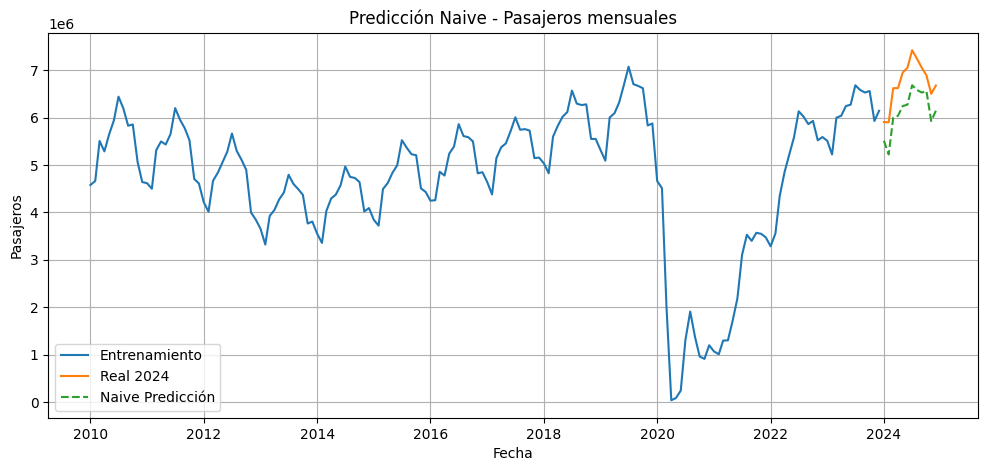

In [14]:
# Modelo Naive

# Agrupación mensual (total de pasajeros por mes)
monthly_df = df_mad.groupby('Fecha')['Pasajeros'].sum().reset_index()

# Convertir 'Fecha' a datetime
monthly_df['Fecha'] = pd.to_datetime(monthly_df['Fecha'])

# Separación de conjunto de entrenamiento y validación (2024)
train_df = monthly_df[monthly_df['Fecha'].dt.year < 2024].copy()
valid_df = monthly_df[monthly_df['Fecha'].dt.year == 2024].copy()


# Definir las series de entrenamiento y validación
y_train = train_df.set_index('Fecha')['Pasajeros']
y_valid = valid_df.set_index('Fecha')['Pasajeros']

# Predicción constante: último valor del conjunto de entrenamiento
# Usamos monthly_df, que tiene 'Fecha' como datetime, y la ponemos como índice para el slicing
monthly_df_indexed = monthly_df.set_index('Fecha')
naive_pred = monthly_df_indexed.loc["2023-01-01":"2023-12-01", "Pasajeros"].values
naive_pred = pd.Series(naive_pred, index=y_valid.index)  # asegurar que el índice coincida con y_valid

# Evaluación del modelo

mae_naive = mean_absolute_error(y_valid, naive_pred)
rmse_naive = np.sqrt(mean_squared_error(y_valid, naive_pred))

# Resultados
print("Modelo Naive")
print(f"MAE: {mae_naive:.2f}")
print(f"RMSE: {rmse_naive:.2f}")

# Visualización
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label="Entrenamiento")
plt.plot(y_valid.index, y_valid, label="Real 2024")
plt.plot(y_valid.index, naive_pred, label="Naive Predicción", linestyle="--")
plt.title("Predicción Naive - Pasajeros mensuales")
plt.xlabel("Fecha")
plt.ylabel("Pasajeros")
plt.legend()
plt.grid(True)

#Guardar la figura
plt.savefig('..\img\prediccion_naive.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
result = adfuller(df_mad['Pasajeros'])
result[1]

2.0967392867623035e-14

Se trata de una serie temporal estacionaria como nos indica el test de ADFuller y con una tendencia creciente por lo que el predictor Naive no arroja un resultado satisfactorio en la comparacion con el conjunto de validacion. 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4850.987, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5659.244, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5540.176, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4852.712, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4852.904, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4840.655, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4842.858, Time=0.08 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=4842.361, Time=0.18 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=4840.557, Time=0.28 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=4839.844, Time=0.11 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=5494.586, Time=0.06 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=4842.079, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5

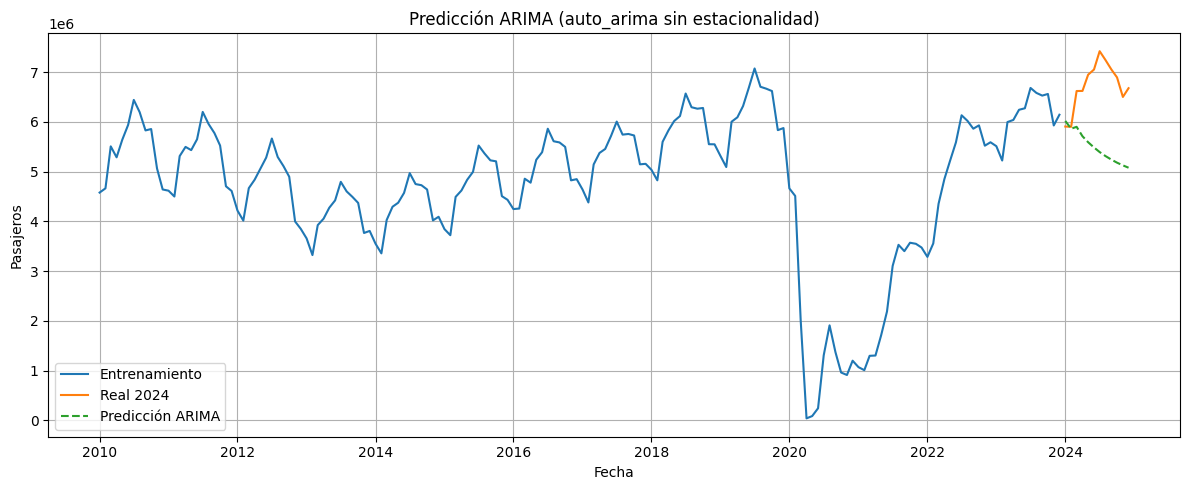

In [16]:
# Ajuste automático SIN estacionalidad
arima_model = auto_arima(
    y_train,
    seasonal=False,   # <--- IMPORTANTE
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Extraer orden ARIMA óptimo
order = arima_model.order

# Entrenar modelo ARIMA puro
model = ARIMA(y_train, order=order)
arima_result = model.fit()

# Predicción
arima_pred = arima_result.predict(start=y_valid.index[0], end=y_valid.index[-1], typ='levels')

# Evaluación
mae_arima = mean_absolute_error(y_valid, arima_pred)
rmse_arima = np.sqrt(mean_squared_error(y_valid, arima_pred))

print(f"\nARIMA (auto_arima sin estacionalidad)")
print(f"Mejor orden ARIMA: {order}")
print(f"MAE: {mae_arima:.2f}")
print(f"RMSE: {rmse_arima:.2f}")

# Visualización
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label="Entrenamiento")
plt.plot(y_valid.index, y_valid, label="Real 2024")
plt.plot(arima_pred.index, arima_pred, label="Predicción ARIMA", linestyle="--")
plt.title("Predicción ARIMA (auto_arima sin estacionalidad)")
plt.xlabel("Fecha")
plt.ylabel("Pasajeros")
plt.legend()
plt.grid(True)
plt.tight_layout()

#Guardar la figura
plt.savefig('..\img\prediccion_arima.png', dpi=300, bbox_inches='tight')
plt.show()

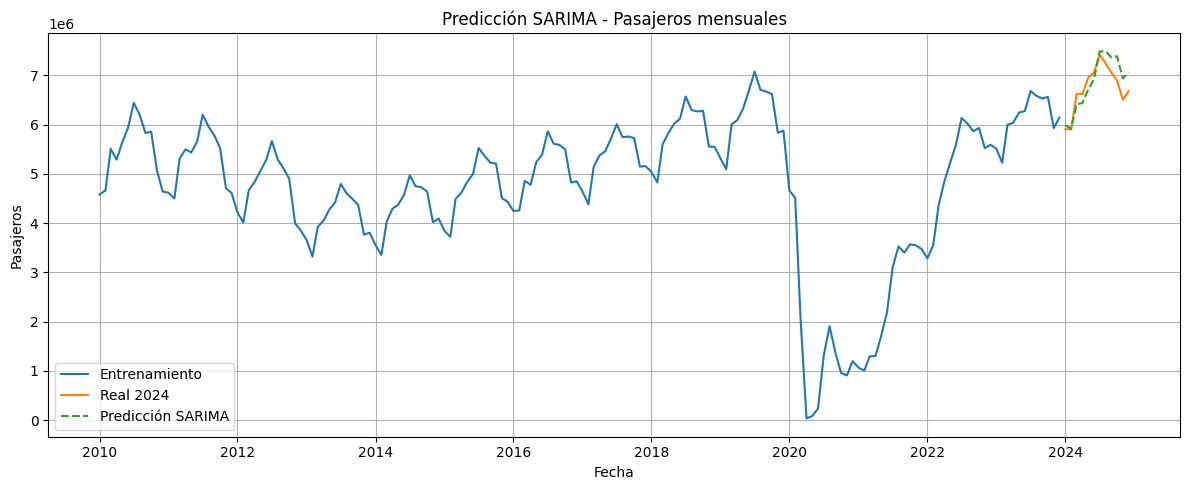

In [17]:
# SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

sarima_model = SARIMAX(
    y_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit(disp=False)

# Predicción
sarima_pred = sarima_result.predict(start=y_valid.index[0], end=y_valid.index[-1])

# Evaluación
mae_sarima = mean_absolute_error(y_valid, sarima_pred)
rmse_sarima = np.sqrt(mean_squared_error(y_valid, sarima_pred))

# Visualización
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label="Entrenamiento")
plt.plot(y_valid.index, y_valid, label="Real 2024")
plt.plot(sarima_pred.index, sarima_pred, label="Predicción SARIMA", linestyle="--")
plt.title("Predicción SARIMA - Pasajeros mensuales")
plt.xlabel("Fecha")
plt.ylabel("Pasajeros")
plt.legend()
plt.grid(True)
plt.tight_layout()

#Guardar la figura
plt.savefig('..\img\prediccion_sarima.png', dpi=300, bbox_inches='tight')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=4816.735, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5248.614, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4834.000, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5133.210, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5659.244, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=4818.876, Time=0.14 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=4814.854, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=4839.858, Time=0.06 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=4816.414, Time=0.57 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=4814.549, Time=0.89 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=4817.353, Time=0.79 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=4817.450, Time=0.50 sec
 ARIMA(2,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(3,0,2)(2,0,1)[12] inte

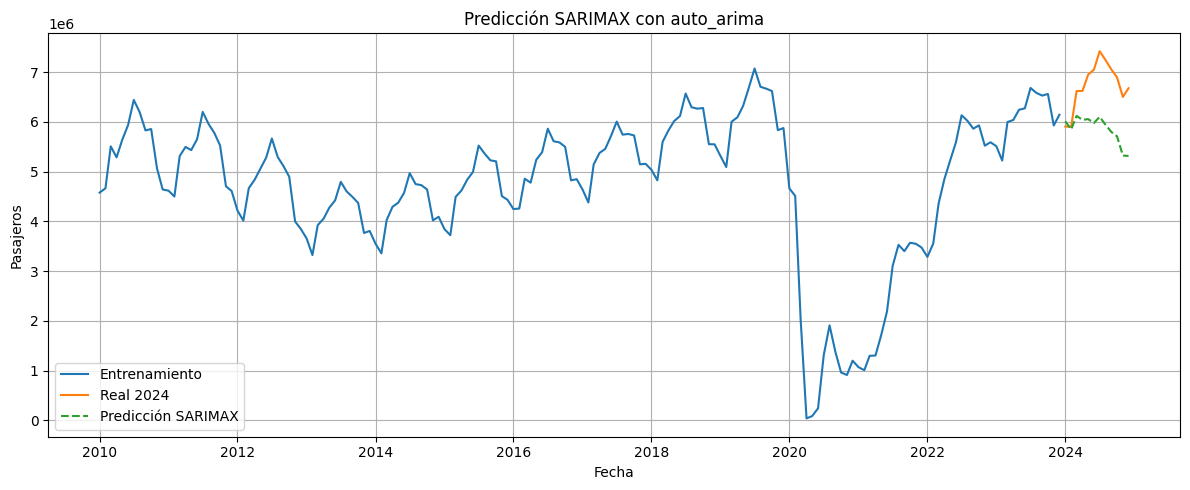

In [18]:
#Modelo Sarimax
#Auto_arima con estacionalidad mensual
auto_model = auto_arima(
    y_train,
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

#Extraer mejores parámetros
order = auto_model.order
seasonal_order = auto_model.seasonal_order

print(f"Mejor modelo SARIMAX encontrado: ARIMA{order} x {seasonal_order}")

#Ajustar SARIMAX
sarimax_model = SARIMAX(
    y_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

#Predicción para 2024
sarimax_pred = sarimax_model.predict(start=y_valid.index[0], end=y_valid.index[-1])

#Evaluación
mae_sarimax = mean_absolute_error(y_valid, sarimax_pred)
rmse_sarimax = np.sqrt(mean_squared_error(y_valid, sarimax_pred))

print(f"\nSARIMAX (con auto_arima)")
print(f"MAE: {mae_sarimax:.2f}")
print(f"RMSE: {rmse_sarimax:.2f}")

#Visualización
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label="Entrenamiento")
plt.plot(y_valid.index, y_valid, label="Real 2024")
plt.plot(sarimax_pred.index, sarimax_pred, label="Predicción SARIMAX", linestyle="--")
plt.title("Predicción SARIMAX con auto_arima")
plt.xlabel("Fecha")
plt.ylabel("Pasajeros")
plt.legend()
plt.grid(True)
plt.tight_layout()
#Guardar la figura
plt.savefig('..\img\prediccion_sarimax.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
comparacion = pd.DataFrame({
    "Modelo": [
        "Naive",
        "ARIMA (auto_arima sin estacionalidad)",
        "SARIMA (manual)",
        "SARIMAX (auto_arima)"
    ],
    "MAE": [
        mae_naive,
        mae_arima,
        mae_sarima,
        mae_sarimax
    ],
    "RMSE": [
        rmse_naive,
        rmse_arima,
        rmse_sarima,
        rmse_sarimax
    ]
})

In [20]:
comparacion

,Modelo,MAE,RMSE
0,Naive,5.942198e+05,6.078357e+05
1,ARIMA (auto_arima sin estacionalidad),1.264182e+06,1.419743e+06
2,SARIMA (manual),2.324957e+05,2.733937e+05
3,SARIMAX (auto_arima),9.010262e+05,1.009257e+06


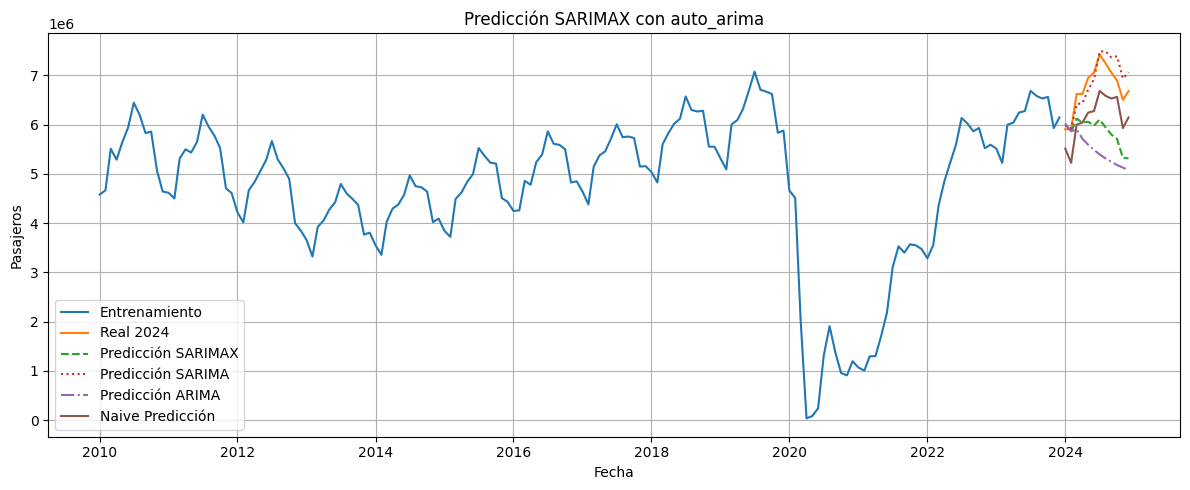

In [21]:
#Visualización
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label="Entrenamiento")
plt.plot(y_valid.index, y_valid, label="Real 2024")
plt.plot(sarimax_pred.index, sarimax_pred, label="Predicción SARIMAX", linestyle="--")
plt.plot(sarima_pred.index, sarima_pred, label="Predicción SARIMA", linestyle=":")
plt.plot(arima_pred.index, arima_pred, label="Predicción ARIMA", linestyle="-.")
plt.plot(y_valid.index, naive_pred, label="Naive Predicción", linestyle="-")
plt.title("Predicción SARIMAX con auto_arima")
plt.xlabel("Fecha")
plt.ylabel("Pasajeros")
plt.legend()
plt.grid(True)
plt.tight_layout()
#Guardar la figura
plt.savefig('..\img\comparacion_predicciones.png', dpi=300, bbox_inches='tight')
plt.show()


## Comparación de Modelos de Predicción de Series Temporales

| Modelo                               | MAE          | RMSE          |
|--------------------------------------|--------------|---------------|
| Naive                                | 594,219.83   | 607,835.72    |
| ARIMA (auto_arima sin estacionalidad)| 1,264,182.35 | 1,419,742.77  |
| SARIMA (manual)                      | 232,495.71   | 273,393.69    |
| SARIMAX (auto_arima)                 | 1,736,328.52 | 1,951,209.73  |

---

## Conclusiones

- **SARIMA (manual)** es claramente el modelo más preciso, mostrando el menor MAE y RMSE. Esto sugiere que considerar explícitamente la estacionalidad mejora sustancialmente la calidad de la predicción.
- El modelo **Naive** ofrece un rendimiento aceptable como base de comparación, pero es superado ampliamente por SARIMA.
- **ARIMA sin estacionalidad** y **SARIMAX automático** presentan errores mucho más altos, probablemente por no capturar adecuadamente los patrones estacionales de la serie temporal.
- A pesar de usar **auto_arima**, **SARIMAX** no logra mejorar las predicciones respecto a SARIMA manual, lo que indica que la configuración automática no fue óptima en este caso específico.

In [22]:
# Guardamos el modelo SARIMA que ha dado mejores resultados
sarimax_model.save('..\models\mad_sarimax.pkl')